<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right!important;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Leroy Deniz Pedreira
</div>

# PEC2: Deep Reinforcement Learning


En esta práctica se implementarán tres modelos de DRL en un mismo entorno, con el objetivo de analizar distintas formas de aprendizaje de un agente y estudiar su rendimiento. El agente será entrenado con los métodos:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
    <li>REINFORCE with baseline </li>
 </ol>

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File  →  Download as  →  HTML.**

**Es necesario adjuntar en la entrega los ficheros .pth con los diferentes modelos entrenados.**

No es necesario adjuntar los ficheros .gif

## 0. Contexto

Uno de los objetivos más actuales del campo de la robótica es conseguir que un robot sea capaz de aprender a realizar una serie de acciones por si sólo, del mismo modo que lo hace un niño pequeño. Esta es, básicamente, una de las principales motivaciones del aprendizaje por refuerzo profundo. Para ello se necesitan sistemas de control eficientes en entornos de alta dimensionalidad como puede ser la inversión en bolsa, conducción de coches autónomos o, incluso, el control de cohetes espaciales. Con esta idea, en esta práctica usaremos un entorno ya predefinido en OpenAI, **Space Invader**.

**Space Invader** consiste en un cañón que puede disparar hacia arriba y moverse de izquierda a derecha. El objetivo del juego es destruir a los extraterrestres enemigos, que se acercan cada vez más rápido al jugador a medida que este los elimina, y maximiza la puntuación. En este entorno, la observación es una imagen RGB de la pantalla representada por una matriz de forma (210, 160, 3) cómo se observa a continuación.




![title](videos/random_agent_space_invader.gif)


Rango de acciones:
* NOOP: 0 ( No operacion).
* FIRE: 1 (disparar sin moverse)
* RIGHT: 2 (mover a la derecha)
* LEFT: 3 (mover a la izquierda)
* RIGHTFIRE: 4 (disparar y mover a la derecha)
* LEFTFIRE: 5 (disparar y mover a la izquierda)


Recompensa: La recompensa devuelta por el entorno está compuesta por un valor en el rango [0, 30]. Dependiendo de la nave alienígena destruida, el agente recibe una puntuación diferente.
 Nuestra tarea es enseñarle una política que le permita hacer una elección "buena" para cada estado.

Para más detalles sobre la definición del entorno de Space Invader, se recomienda consultar las web: <href>https://www.gymlibrary.dev/environments/atari/space_invaders/</href> y  <href>https://atariage.com/manual_html_page.php?SoftwareLabelID=460</href>


## 1. Inicialización y exploración del entorno (1 pto)
**IMPORTANTE**: el entorno Space Invader depende de la instalación de los siguientes paquetes
<ul>
     <li>gym[atari] en la versión 0.25.0</li>
     <li>autorom[accept-rom-license]</li>
</ul>

Este entorno puede ser ejecutado tanto en local como en Kaggle con la versión de GPU P100 y en Google Colab. Recomiendo utlizar Kaggle para los estudiantes que no dispongan de una GPU en local.

Empezaremos cargando las principales librerías necesarias para la práctica:


Usado capture para omitir los mensajes de instalación

In [1]:
%%capture
!pip3 install ale-py
!pip3 install 'gym[atari]'==0.25.0
!pip3 install 'autorom[accept-rom-license]'
!pip3 install imageio
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install rgb2gray

In [2]:
#instalación de librerías.
import warnings
warnings.filterwarnings('ignore')
import time
import gym
import torch
import matplotlib.pyplot as plt
from ale_py import ALEInterface
ale = ALEInterface()

from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from skimage import transform
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Game console created:
  ROM file:  /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/AutoROM/roms/space_invaders.bin
  Cart Name: Space Invaders (1978) (Atari) [!]
  Cart MD5:  72ffbef6504b75e69ee1045af9075f66
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        4096
  Bankswitch Type: AUTO-DETECT ==> 4K

Running ROM file...
Random seed is 1670894458


In [3]:
# Custom imports

from skimage.color import rgb2gray # Transformación a escala de grises
from tqdm import tqdm # Librería para mostrar avance en iteraciones
import datetime # Para medir el tiempo de ejecución
import statistics as std # Para utilizar funciones como mean
from collections import deque # Manejo de pilas con un máximo de n elementos, definidos

In [4]:
# Comprobación de la versión de GYM instalada
print('La versión de gym instala: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)

La versión de gym instala: 0.25.0
El entorno utiliza:  cpu



Comprueba que la celda anterior indica que la verisón instalada de Gym es la 0.25.0.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.2 ptos):</strong> Inicializar el entorno 'SpaceInvaders-v4'. Extraer:
<ul>
 <li> Valor del umbral de recompensa definido en el entorno</li>
 <li> Máximo número de pasos establecidos para cada episodio</li>
 <li> La dimensión del espacio de acciones</li>
 <li> La dimensión del espacio de observaciones.</li>
 </ul>
</div>


In [5]:
warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

print(f"Umbral de recompensas: {env.reward_range}")
print(f"Máximo número de pasos por episodio: {env.spec.max_episode_steps}")
print(f"Dimensión del espacio de acciones: {env.action_space.n} - {env.get_action_meanings()}")
print(f"Dimensiones del espacio de observaciones: {env.observation_space}")

Umbral de recompensas: (-inf, inf)
Máximo número de pasos por episodio: 100000
Dimensión del espacio de acciones: 6 - ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del espacio de observaciones: Box(0, 255, (210, 160, 3), uint8)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


En el aprendizaje por refuerzo suele ser muy útil visualizar el comportamiento de un agente en su entorno. Para esta PEC es interesante poder almacenar el comportamiento visual de un agente en forma de archivo .gif.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.2 ptos):</strong>  En este ejericicio os proponemos almacenar en una carpeta videos un ejemplo de actuación del agente aleatorio en forma de archivo .gif.

    -----------------------------------------------------------------------------------------------------------
    
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>


In [6]:
#Método para generar la imagen a partir de un estado con un texto informativo.
def _label_with_text(frame):
    '''
    frame: estado de un entorno GYM.
    '''
    im = Image.fromarray(frame)
    im = im.resize((im.size[0]*2,im.size[1]*2))
    drawer = ImageDraw.Draw(im)
    drawer.text((1, 1), "Uoc Aprendizaje Por Refuerzo.", fill=(255, 255, 255, 128))
    return im

#Método que permite crear un gif con la evolución de una partida dado un entorno GYM.
def save_random_agent_gif(env):
    frames = []
    done = False
    env.reset()
    ###########################################
    #Jugar una partida aleatoria.
    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)
    ##############################################

    env.close()
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_space_invader_usuario.gif'), frames, fps=60)

In [7]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
try:
    os.makedirs('videos')
except:
    pass
save_random_agent_gif(env)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.3 (0.3 ptos):</strong> Ejecutar 1000 episodios con el máximo de pasos establecido en el entorno de Space Invader, tomando acciones de forma aleatoria. Almacenar la suma de recompensas de cada partida y la cantidad de episodios ejecutados. Mostrar:
    <ul>
       <li>Histograma con la suma de recompensas de cada partida</li>
       <li>Histograma con la cantidad de pasos para resolver cada partida. </li>
    </ul>
</div>

In [8]:
steps, rewards = [], []
n = 1000
for _ in tqdm(range(n), ncols=100, desc="Ejecutando"):
    done, n_step, total_reward = False, 0, 0
    env.reset()
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)

        # Se actualizan las variables temporales
        n_step += 1
        total_reward += reward
    
    steps.append(n_step), rewards.append(total_reward)

Ejecutando: 100%|███████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


Text(0, 0.5, 'Partidas')

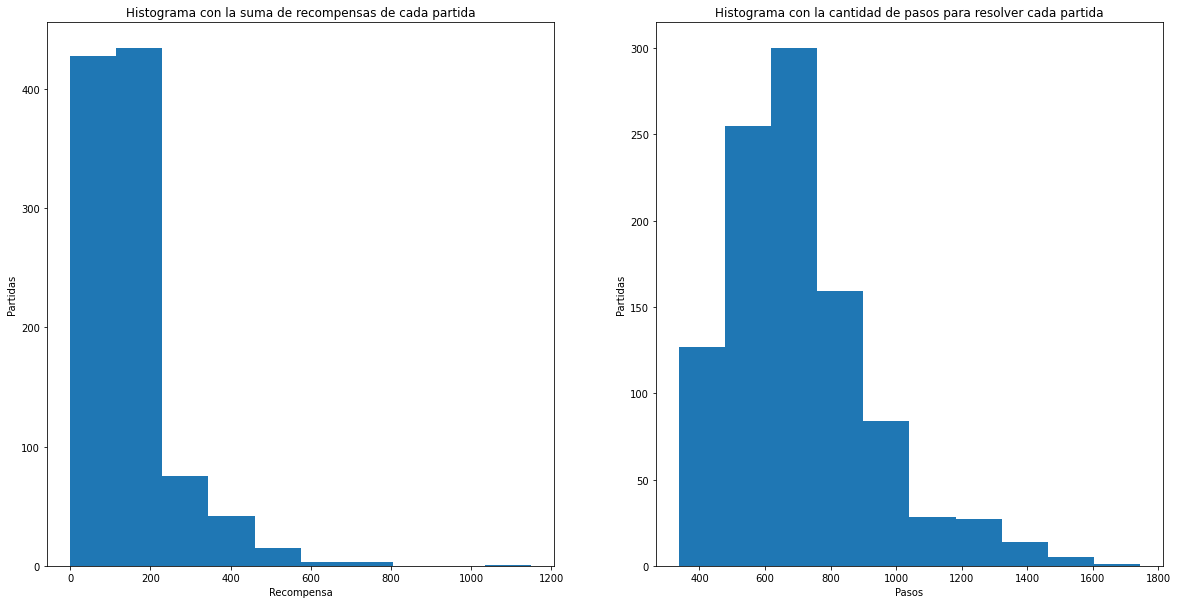

In [9]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax[0].hist(x=rewards)
ax[0].set_title('Histograma con la suma de recompensas de cada partida')
ax[0].set_xlabel('Recompensa')
ax[0].set_ylabel('Partidas')


ax[1].hist(x=steps)
ax[1].set_title('Histograma con la cantidad de pasos para resolver cada partida')
ax[1].set_xlabel('Pasos')
ax[1].set_ylabel('Partidas')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis (0.3 ptos):</strong> ¿Cuál es la media de recompensas obtenida? ¿Y la media de pasos por episodio? Comenta los resultados obtenidos.
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
</div>

In [10]:
print(f"La media de recompensas obtenidas es {std.mean(rewards)}")
print(f"La media de pasos por episodio es de {round(std.mean(steps),0)}")

La media de recompensas obtenidas es 151.885
La media de pasos por episodio es de 700.0


## 2. Agente DQN (2.8 ptos)
En este apartado implementaremos una solución DQN para intentar obtener un modelo que nos permita solucionar este entorno. Primeramente definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del agente entrenado.


### 2.1 Procesamiento de las observaciones.


El primer paso es entender la estructura de la información que nos proporciona el entorno. Los juegos de Atari utilizan un espacio de acción con una estructura de la siguiente forma (210, 160, 3), es decir, 210 pixeles de anchura, 160 de altura y 3 colores (RGB). Cada uno de estos puntos de la estructura es un pixel de color y posee un rango de valores que van desde el 0 hasta 255, lo que nos da $256^{(210x160x3)}$ = $256^{100800}$ posibilidades (a modo de comparación, tenemos aproximadamente $10^{80}$ átomos en el universo observable)

<p></p>
<img src="imagenes/atomos.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.1 Análisis (0.2 pto):</strong> ¿Es posible implementar una solución tabular vista durante la PEC1 en este entorno de Space Invader?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br><br>Definitivamente NO, puesto que requeriría de una tabla de dimensionalidad demasiado grande y no sería una solución realista, además la cantidad de casos a entrenar es increíblamente grande. Por eso se busca aproximar una función que decida en el momento qué acción tomar.
</div>

En este caso, la mejor idea es, dado un estado, aproximar los valores Q para cada posible acción en ese estado. Es decir, implementaremos la solución que puedes observar en la siguiente figura.

<p></p>
<img src="imagenes/deep.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<p></p>

Ahora bien, en el juego Space Invader no todo el espacio posee utilidad. El marcador, el marco o la cantidad de vidas no es necesario para el desarrollo del juego. Una práctica muy habitual en el aprendizaje por refuerzo es reducir las dimensiones del entorno con el objetivo de disminuir la cantidad de cálculos necesarios para obtener un modelo útil para el entorno.

Exactamente, para esta PEC os vamos a pedir reducir el espacio de los frames a 84 x 84 píxeles, reducir nuestros tres canales de color (RGB) a 1 (blanco y negro), normalizar el resultado y, por último, almacenar los 4 últimos frames cómo se muestra en la siguiente figura:
<p></p>
<img src="imagenes/preprocessing.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2  (0.1 pto):</strong> Define el metodo scale_lumininance para, dado un estado, transformar los puntos del sistema RGB al sistema binario blanco y negro
</div>

In [11]:

def scale_lumininance(obs):
    return np.dot(obs[...,:3], [0.299, 0.587, 0.114])


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.3 (0.1 pto):</strong> Define el metodo resize para, dado un estado, redimensionar su tamaño a 84 * 84
</div>

In [12]:

def resize(obs):
    return transform.resize(obs, (84, 84))


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.4 Ejercicio (0.1 pto):</strong> Define el metodo normalize para, dado un estado, normalice la imagen
</div>

In [13]:

def normalize(obs):
    return obs / 255


El resultado que vas a obtener será el siguiente:
<p></p>
<table  border="0">
<thead>
  <tr style='border:none;' >
    <th style='border:none;' ><img src="imagenes/preprocess_grey.png"  width="500"></th>
    <th style='border:none;'><img src="imagenes/preprocess_normalize.png"  width="500"></th>
    <th style='border:none;' ><img src="imagenes/preprocess_size.png"  width="500"></th>
  </tr>
</thead>
<tbody>
  <tr style='border:none;'>
    <td style='text-align: center; border:none;'> 1.scale_lumininance(obs) </td>
    <td style='text-align: center; border:none;'> 2.resize(obs) </td>
    <td style='text-align: center; border:none;'> 3.normalize(obs)</td>
  </tr>
</tbody>
</table></div>


In [14]:
env.render(mode='rgb_array')
action = env.action_space.sample()
state, reward, done, _ = env.step(action)

# Función que realiza todo el pre-procesado de una observación
def preprocess_observation(obs):
    obs_proc = scale_lumininance(obs)
    obs_proc = resize(obs_proc)
    obs_proc = normalize(obs_proc)
    return obs_proc

Por último, ¿cómo interpretamos el movimiento? Las imágenes corresponden a información estática de las partidas y, en este entorno, es importante conocer la dirección del disparo o el movimiento de los invasores. Para ello, una forma de gestionar esta información es apilando fotogramas para poder proporcionar al algoritmo información acerca de la progresión de la partida.


Utilicemos un ejemplo muy claro, el Ping Pong:
<p></p>
<img src="imagenes/temporal-limitation-2.png"  width="1000">

Fíjate cómo la pelota se desplaza hacia la derecha. La agrupación de los frames nos permite trasladar la información espacial a nuestro algoritmo.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.5  (0.1 ptos):</strong> Implementa la función stack_frame para apilar 4 frames de una partida. Dicha función debe apilar inicialmente (cuando is_new = True) el mismo frame 4  veces para, posteriormente, conforme se vayan introduciendo nuevos frames ir substituyendo a los más antiguos.
</div>

In [15]:
def stack_frame(stacked_frames, frame, is_new):
        """Stacking Frames.
        Params
        ======
            stacked_frames (array): array de frames (al devolverlo debe tener 4 frames)
            frame: Nueva imagen a añadir (hay que borrar la más antigua)
            is_new: Primera vez que se utiliza el array.
        """
        
        # Pre procesado
        frame = preprocess_observation(frame)

        if is_new:
            # Se eliminan los frames anteriores
            stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(4)], maxlen=4)

            # Como estamos en un nuevo episodio, se añade el mismo 4 veces
            for _ in range(4):
                stacked_frames.append(frame)

        else:
            # Añadir la nueva imagen
            stacked_frames.append(frame)
        
        return stacked_frames

Una vez creada la función la testeamos jugando una partida, almacenando los 4 frames más recientes en cada paso, y finalmente mostramos los 4 últimos frames de la partida.

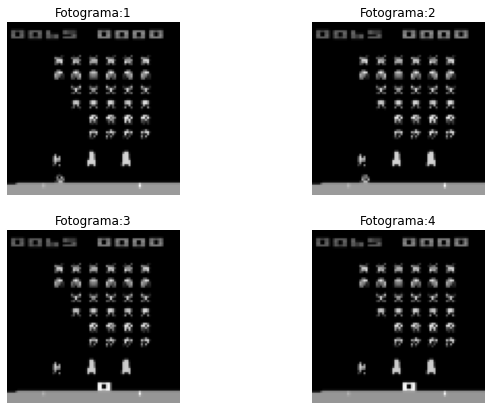

In [16]:
# Llenamos 'state_stack' con 4 copias idénticas del frame inicial de la partida
state_stack= stack_frame(None, env.reset(), True)

# Jugamos una partida aleatoria y vamos actualizando los 4 frames de 'state_stack'
# conforme se van produciendo nuevos
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    state_stack = stack_frame(state_stack, next_state, False)

    if done:
         break

# Mostramos los últimos 4 frames de la partida que han quedado almacenados en 'state_stack'
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cont=1

for index, i in enumerate(state_stack):
    fig.add_subplot(rows, columns, index+1)
    plt.imshow(i, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Fotograma:' + str(index+1))

Ahora con estas modificaciones podemos pasar al siguiente punto, la creación de la Red
<p></p>
<img src="imagenes/deep-q-network.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

Cómo se observa en la imagen, utilizaremos un modelo convolucional (perfecto para detectar patrones en imágenes) junto con un sistema lineal completamente conectado. Para la red convolucional os proponemos la siguiente configuración:

<ul>
    <li>Una primera capa del tipo Conv2d con los siguientes parámetros in_channels=4, out_channels=32, kernel_size=8, stride=4 con activación ReLU.</li>
    <li>Una segunda capa del tipo Conv2d con los siguientes parámetros in_channels=32, out_channels=64, kernel_size=4, stride=2 con activación ReLU.</li>
    <li>Una tercera capa del tipo Conv2d con los siguientes parámetros in_channels=64, out_channels=64, kernel_size=3, stride=1 con activación ReLU.</li>
</ul>

El resultado de esta primera red (3D) lo conectaremos con un modelo completamente conectado (1D) con la siguiente estructura lineal:

* Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU
* Una última capa completamente conectada. Esta será nuestra capa de salida y, por lo tanto, tendrá tantas neuronas como dimensiones tenga nuestro espacio de acciones (una salida por cada acción posible).

Por último, usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.6 (0.5 ptos):</strong>Implementar la clase  <code>DQN_CNN()</code>. Inicializar las variables necesarias y definir el modelo CNN y linial indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.

</div>

In [17]:
import torch.nn as nn
class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        device: cpu o cuda
        red_cnn: definición de la red convolucional
        red_lineal: definición de la red lineal
        """
        #######################################
        ###TODO: inicialización y modelo###
        self.input_shape = [4,84,84]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcción de la red neuronal convolucional
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        if torch.cuda.is_available():
            self.red_cnn.cuda()

            
        self.fc_layer_inputs = self.feature_size()
        
        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs, bias=True)
        )

        if torch.cuda.is_available():
            self.red_lineal.cuda()


        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        return self.red_lineal(cnn_out)


    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)



Definimos la clase para el *buffer* de repetición de experiencias:


In [18]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use el operador asterisco para desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.2 Definición del agente


A continuación implementaremos una clase que defina el entrenamiento del agente teniendo en cuenta:
    <ul>
        <li>La exploración/explotación (decaimiento de epsilon)</li>
        <li>La actualización y sincronización de la red principal y la red objetivo (pérdida)</li>
    </ul>

Además, vamos a considerar que el agente ha superado el entorno cuando obtenga una puntuación superior a 350 en 100 partidas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.7 (1 pto):</strong> Implementar los siguientes puntos de la clase <code>DQNAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Actualizar la red principal según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la ecuación de Bellman</li>
        <li>Sincronizar la red objetivo según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Actualizar epsilon según: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [19]:
from copy import deepcopy, copy
class DQNAgent:
    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorno
        main_network: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # últimos episodios a evaluar
        self.reward_threshold = reward_threshold
        self.initialize()

    ###############################################################
    #####TODO 2: inicializar variables extra que se necesiten######
    def initialize(self):
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.epsilon_history = []
        self.update_loss = []
        self.losses = []
        self.mean_training_rewards = []
        self.training_rewards = []
        incio_juego = self.env.reset()
        self.state0 = stack_frame(None, incio_juego, True)


    #################################################################################
    ######TODO 3:  Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, done, _ = self.env.step(action) 
        new_state = stack_frame(self.state0, new_state, False) #Recordar preprocesar los estados
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = new_state

        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = stack_frame(None, env.reset(), True) #Recordar preprocesar los estados
        return done



    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = 0
        while training:
            self.state0 = stack_frame(None, env.reset(), True) #Recordar preprocesar los estados
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                ###TODO 4: Actualizar red principal según la frecuencia establecida#####
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards y loss   #######
                    self.epsilon_history.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)
                    self.losses.append(np.mean(self.update_loss))
                    self.update_loss = []
                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(   # calculamos la media de recompensa de los últimos X episodios
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = mean_rewards if mean_rewards > maximo else maximo
                    
                    ##################################################################

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maximo {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print(f'\nEnvironment solved in {episode} episodes!')
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)


    ####################################
    #####TODO 5: Cálculo de la pérdida ####
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q de la red objetivo El parametro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales

        #################################################################################
        ###TODO: Calculamos ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals

        # Cálculo de pérdida
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss


    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch)# calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

### 2.3 Entrenamiento
A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.001 </li>
        <li>Tamaño del batch: 32</li>
        <li>Capacidad máxima del buffer: 8000</li>
        <li>Gamma: 0.99</li>
        <li>Epsilon: 1, con decaimiento de 0.995 con un mínimo de 0.01</li>
        <li>Número de steps para rellenar el buffer: 100</li>
        <li>Número máximo de episodios: 5000</li>
        <li>Número minímo de episodios: 250</li>
        <li>Frecuencia de actualización de la red neuronal: 100 </li>
        <li>Frecuencia de sincronización con la red objetivo: 5000</li>
    </ul>

Es probable que con los hiperparámetros propuestos no se llegue a solucionar el entorno (conseguir una puntuación de 350 en la media de 100 partidas). El objetivo principal es mejorar los resultados del agente aleatorio.

Está permitido realizar modificaciones en los parámetros presentados aunque, el último ejercicio de esta PEC, consiste en mejorar los resultados obtenidos con este entrenamiento.  Por lo tanto, aunque esté permitido, no es recomendable.

Si el alumno no dispone de suficiente tiempo puede acortar el tiempo de entrenamiento fijando el Número máximo de episodios = 3000 en lugar de los 5000 propuestos.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.8 (0.1 ptos):</strong> Declarar los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente
</div>

In [20]:
lr = 0.001            #Velocidad de aprendizaje
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 1500   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo
MAX_SCORE = 350       #Puntuación establecida para definir la ganancia

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dqn = DQN_CNN(env, learning_rate=lr)

# Cargar el agente
agent = DQNAgent(env, dqn, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 1500 Mean Rewards 202.50 Epsilon 0.01 , Maximo 300.00		Maximo 300.00		
Episode limit reached.


Se reduce el número máximo de episodios a 1500 para reducir el tiempo de procesamiento.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.9 (0.1 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamieno, la evolución de las recompensas medias y el umbral de recompensa establecido por el entorno.</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
</div>

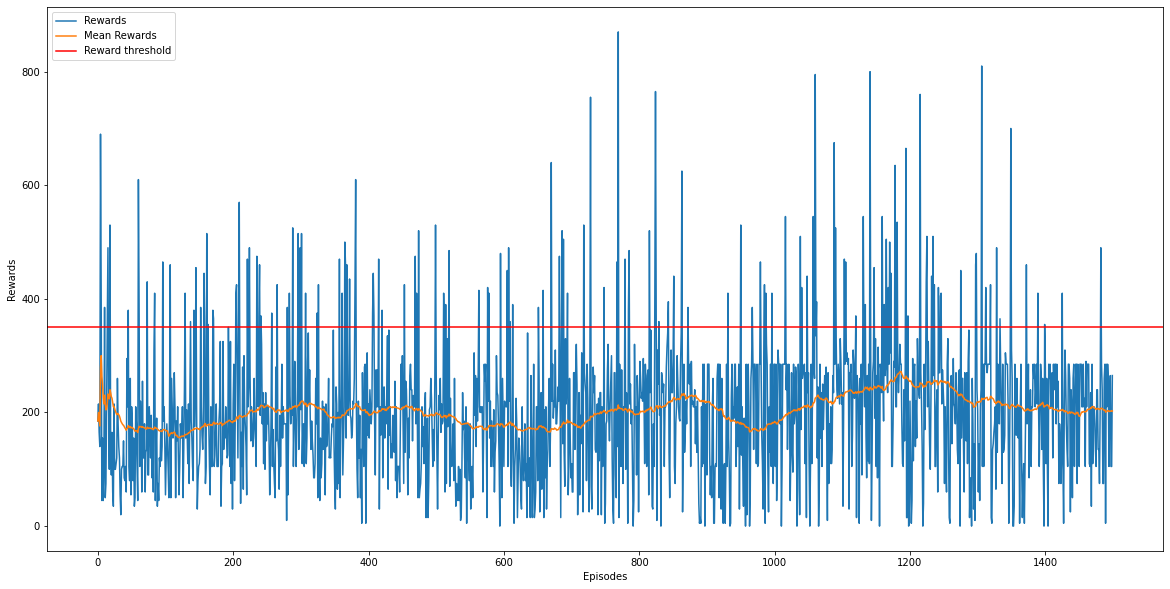

In [21]:
# 1. Recompensas obtenidas a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(agent.training_rewards, label='Rewards')
plt.plot(agent.mean_training_rewards, label='Mean Rewards')
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

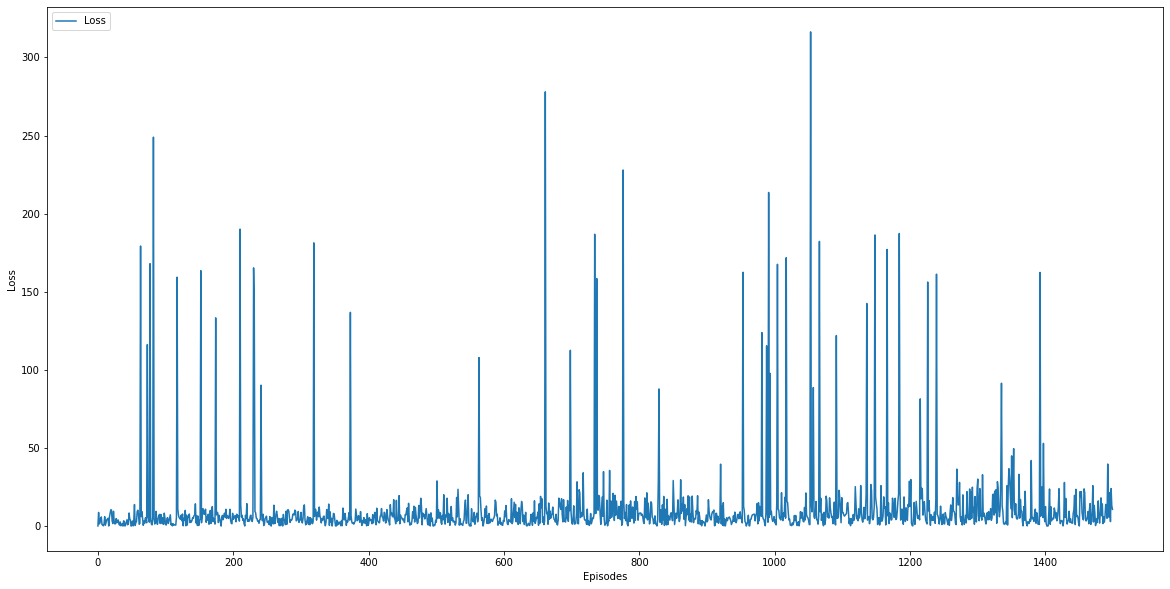

In [22]:
# 2. Evolución de la pérdida a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(agent.losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

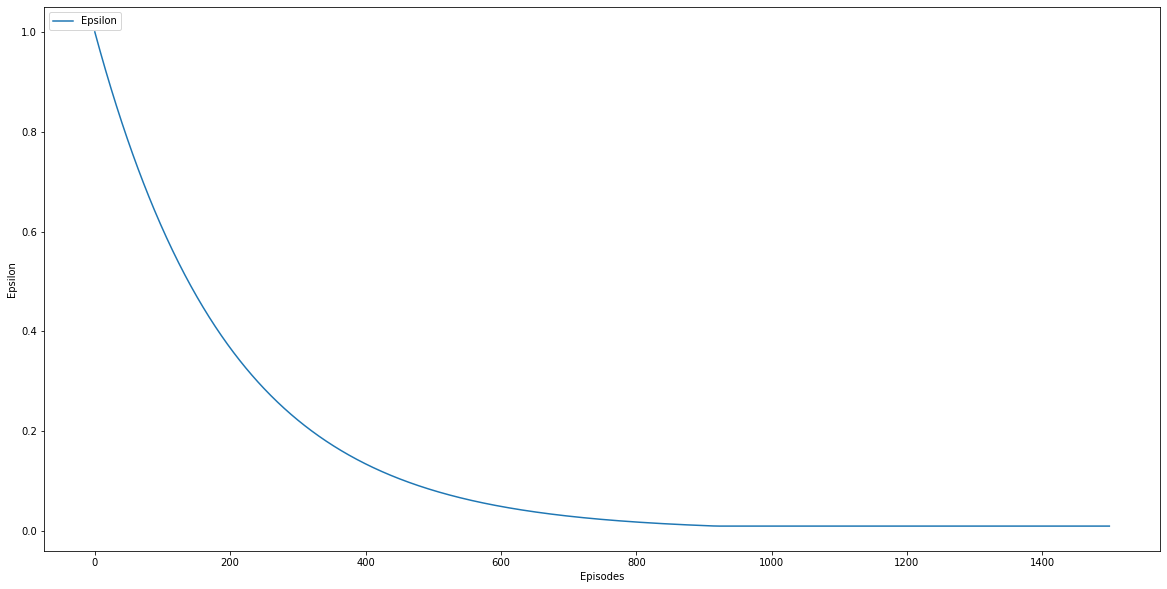

In [23]:
# 3. Evolución de epsilon a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(agent.epsilon_history, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.10 (0.1 ptos):</strong> Comenta los resultados
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
Las recompensas obtenidas mejoran significativamente en los primeros episodios, sin embargo, conforme van transcurriendo, oscilan de manera estable en un intervalo. El epsilon por su parte, decrece constantemente tal como puede verse en la gráfica y así como ha sido establecido, con un valor inicial de 1, un valor final de 0.01 y un decaimiento de 0.995, es decir que la probabilidad de seleccionar una acción aleatoria comienza con un valor de epsilon y disminuirá logarítmicamente.

</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.11 (0.1 pto):</strong> Guardar el modelo entrenado en formato ".pth".
</div>

In [24]:
torch.save(agent.main_network.state_dict(), './models/agentDQN_Trained_Model_dqn_cnn.pth')

### 2.4 Test del agente entrenado

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido, si el "robot" es capaz de realizar las tareas aprendidas. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones aleatorias según ese modelo y observamos su comportamiento.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.12 (0.2 pto):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas para cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno.

</div>

In [25]:
# Cargar el modelo de red neuronal
dqn = DQN_CNN(env, learning_rate=lr)

# Cargar el agente aleatorio
agentDQN = DQNAgent(env, dqn, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Definir la red principal del agente con la red entrenada
agentDQN.main_network.load_state_dict(torch.load('./models/agentDQN_Trained_Model_dqn_cnn.pth'))

def agent_run(env, ag):
    
    observation = env.reset()
    incio_juego = observation
    state= stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    while True:
        state = stack_frame(state, observation, False)
        action = ag.main_network.get_action(state,epsilon=0.0)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1
        if done:
            break
    env.close()
    return total_reward


# Ejecutar los episodios pedidos
episodes = 20
total_rewards = []

for _ in tqdm(range(episodes), ncols=100, desc="Jugando"):
    reward = agent_run(env, agentDQN)
    total_rewards.append(reward)

Jugando: 100%|██████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.50s/it]


In [26]:
##TODO: Calcular la suma de recompensas
for i, suma in enumerate(total_rewards):
    print(f"Episode {i+1} - {total_rewards[i]}")

Episode 1 - 285.0
Episode 2 - 285.0
Episode 3 - 285.0
Episode 4 - 285.0
Episode 5 - 285.0
Episode 6 - 285.0
Episode 7 - 285.0
Episode 8 - 285.0
Episode 9 - 285.0
Episode 10 - 285.0
Episode 11 - 285.0
Episode 12 - 285.0
Episode 13 - 285.0
Episode 14 - 285.0
Episode 15 - 285.0
Episode 16 - 285.0
Episode 17 - 285.0
Episode 18 - 285.0
Episode 19 - 285.0
Episode 20 - 285.0


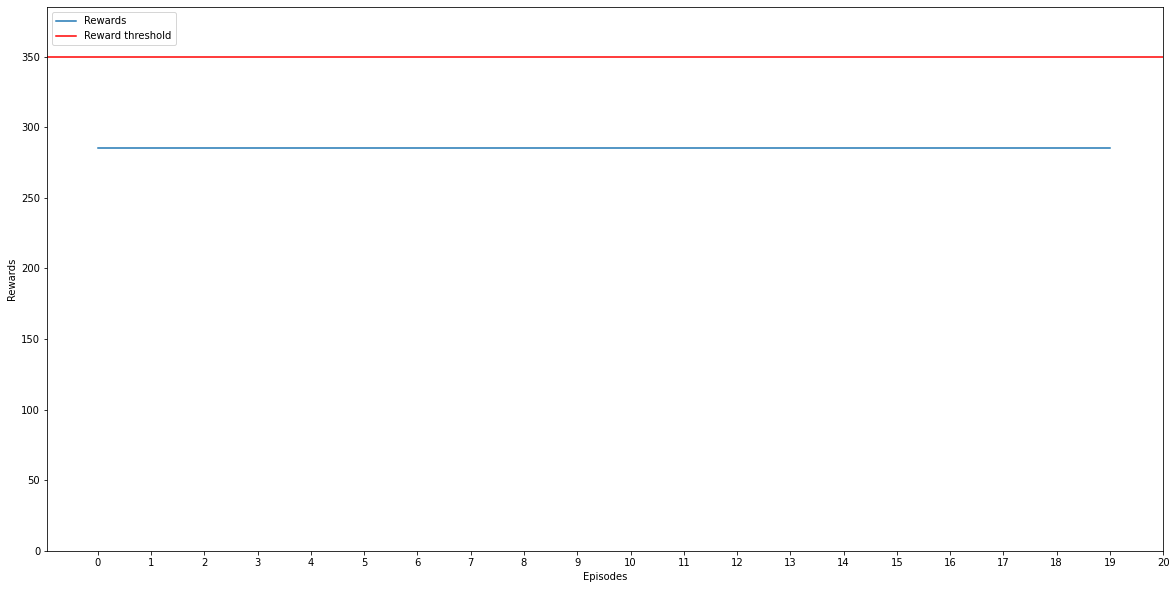

In [27]:
##TODO: realizar las gráficas que se piden
plt.figure(figsize=(20,10))
plt.plot(total_rewards, label='Rewards')
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.xticks(range(episodes+1))
plt.ylabel('Rewards')
plt.ylim([0,agent.reward_threshold*1.1])
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 2.13 (0.1 pto):</strong> Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento (se da el código hecho) y comenta el comportamiento del agente entrenado.
</div>

In [28]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
def save_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorno GYM
    :param ag:  agente entrenado
    :param nombre_fichero:  nombre del fichero
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    incio_juego = observation
    state= stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    while True:
            state= stack_frame(state, observation, False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))
            action = ag.main_network.get_action(state,epsilon=0.0)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)
save_agent_gif(env,agentDQN, 'agente_dqn.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br><br>
El comportamiento del agente es exactamente el que se muestra en la imagen debajo, únicamente opta por realizar movimientos a la derecha o quedarse donde está pero sin realizar ningún disparo, por lo que en ningún momento toma la acción de disparar y su recompensa media es 0. Se podría interpretar que con 1500 casos aún no ha aprendido a disparar en estas situaciones. Se adjunta la imagen obtenida:
    
</div>


![title](videos/agente_dqn.gif)

Puede ser que el resultado sea muy parecido al siguiente GIF. No os preocupéis, con los parámetros escogidos es difícil obtener unos mejores resultados.
![title](videos/space_invader_dqn_comportamiento_continuo.gif)

## 3. Agente Dueling DQN (2.2 ptos)

En este apartado resolveremos el mismo entorno con las mismas características para el agente, pero usando una dueling DQN. Como en el caso anterior, primero definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del mismo.

### 3.1 Definición de la arquitectura  de la red neuronal


El objetivo principal de las dueling DQN es "ahorrarse" el cálculo del valor de Q en aquéllos estados en los que es irrelevante la acción que se tome. Para ello se descompone la función Q en dos componentes:


$$Q(s, a) = A(s, a) + V (s)$$


Esta descomposición se realiza a nivel de la arquitectura de la red neuronal. Las primeras capas que teníamos en la DQN serán comunes, y luego la red se dividirá en dos partes separadas definidas por el resto de capas.

La descomposición en sub-redes del modelo de la DQN implementada en el apartado anterior, será entonces:
<ol>
    <li>Bloque común, la red CNN</li>
    <li>Red advantage A(s,a):</li>
         <ul>
             <li>Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU</li>
             <li>Una última capa completamente conectada. Esta será nuestra capa de salida y por lo tanto el número de neuronas de salida dependerá del tipo de red, A(s,a) en este caso, y tendrá tantas neuronas como dimensiones tenga el espacio de acciones.</li>
             </ul>
    <li>Red value V(s):</li>
            <ul>
             <li>Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU</li>
             <li>Una última capa completamente conectada. Esta será nuestra capa de salida con un valor por estado.</li>
             </ul>
</ol>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.1 (0.75 ptos):</strong> Implementar la clase <code>duelingDQN()</code>. Inicializar las variables necesarias y definir el modelo de red neuronal indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [29]:
class duelingDQN(torch.nn.Module):
    ###################################
    ###TODO: inicialización y modelo###
    def __init__(self, env, learning_rate=1e-3):
        """
        Params
        ======
        input_shape: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        device: cpu o cuda
        red_cnn: definición de la red convolucional
        value: definición de la red lineal value
        advantage: definición de la red lineal advantage
        """
        ###################################
        ####TODO: Inicializar variables####
        super(duelingDQN, self).__init__()
        self.input_shape = [4,84,84]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        #######################################
        ##TODO: Construcción de la red neuronal
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        if torch.cuda.is_available():
            self.red_cnn.cuda()
            
        self.fc_layer_inputs = self.feature_size()
            
        self.advantage = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        ### Se ofrece la opción de trabajar con cuda
        if self.device == 'cuda':
            self.value.cuda()
            self.advantage.cuda()
        
        
        ### Inicializamos el optimizador
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #######################################
    #####TODO: función forward#############
    def forward(self, x):
        cnn_out = self.red_cnn(x).reshape(-1, self.fc_layer_inputs)
        value_out = self.value(cnn_out)
        advantage_out = self.advantage(cnn_out)
        qvals = value_out + (advantage_out - advantage_out.mean())
        return qvals

    ### Método e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción aleatoria
        else:
            qvals = self.get_qvals(state)  # acción a partir del cálculo del valor de Q para esa acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)


    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)


Para el buffer de repetición de experiencias podemos usar exactamente la misma clase experienceReplayBuffer descrita en el apartado anterior de la DQN.



### 3.2 Definición del agente


La diferencia entre la DQN y la dueling DQN se centra, como hemos visto, en la definición de la arquitectura de la red. Pero el proceso de aprendizaje y actualización es exactamente el mismo. Así, podemos recuperar la clase implementada en el apartado anterior, DQNAgent() y reutilizarla aquí bajo el nombre de duelingDQNAgent(). Lo único que deberemos hacer es añadir el optimizador entre las variables a declarar y adaptar la función de pérdida al formato Functional de pytorch.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.2 (0.5 pto):</strong> Implementar la clase <code>duelingDQNAgent()</code> como la <code>DQNAgent()</code>
<p>
</p>
De nuevo, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
    </div>

In [30]:
class duelingDQNAgent:
 ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32):
        """"
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100
        self.reward_threshold = reward_threshold
        self.initialize()

    ###############################################################
    #####TODO 2: inicialitzar variables extra que es necesiten######
    def initialize(self):
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.epsilon_history = []
        self.update_loss = []
        self.losses = []
        self.mean_training_rewards = []
        self.training_rewards = []
        incio_juego = self.env.reset()
        self.state0 = stack_frame(None, incio_juego, True)


    #################################################################################
    ######TODO 3:  Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa
        new_state, reward, done, _ = self.env.step(action)   #
        new_state = stack_frame(self.state0, new_state, False)

        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = new_state.copy()

        #TODO: resetear entorno 'if done'
        if done:
            incio_juego = self.env.reset()
            self.state0 = stack_frame(None, incio_juego, True)
        return done



    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = 0
        while training:
            self.state0 = stack_frame(None, env.reset(), True) #Recordar preprocesar los estados
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                #####TODO 4: Actualizar la red principal según la frecuencia establecida  #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards y loss#######
                    self.epsilon_history.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)
                    self.losses.append(np.mean(self.update_loss))
                    self.update_loss = []

                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(   # calculamos la media de recompensa de los últimos X episodios
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = mean_rewards if mean_rewards > maximo else maximo
                    ###


                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maximo {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print(f'\nEnvironment solved in {episode} episodes!')
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)


     ## Cálculo de la pérdida
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.device)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        #DQN update#
        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        if self.device == 'cuda':
            next_actions_vals = next_actions.reshape(-1,1).to(device=self.device)
        else:
            next_actions_vals = torch.LongTensor(next_actions).reshape(-1,1).to(device=self.device)
            
        # Obtenemos los valores de Q de la red objetivo
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()
        #####

        qvals_next[dones_t] = 0 # 0 en estados terminales

        #TODO: Calculamos ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Función Loss######
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        #######
        return loss



    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

### 3.3 Entrenamiento
A continuación entrenaremos el modelo dueling DQN con los mismos hiperparámetros con los que entrenamos la DQN.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.3 (0.1 ptos):</strong> Cargar el modelo de red neuronal y entrenar el agente con los mismos hiperparámetros usados para la DQN
</div>

In [31]:
lr = 0.001            #Velocidad de aprendizaje
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 1500   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo
MAX_SCORE = 350       #Puntuación establecida para definir la ganancia

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dueling_dqn = duelingDQN(env, learning_rate=lr)

# Cargar el agente
ddqn_agent = duelingDQNAgent(env, dueling_dqn, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
ddqn_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 1500 Mean Rewards 249.75 Epsilon 0.01 , Maximo 275.80		Maximo 271.75		
Episode limit reached.


Se reducen a 1500 los casos de entrenamiento.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.4 (0.2 ptos):</strong> Mostrar los mismos gráficos que con la DQN:
    <ol>
        <li>Recompensas obtenidas a lo largo del entrenamiento y la evolución de las recompensas medias cada 100 episodios, junto con el umbral de recompensa establecido por el entorno</li>
        <li>Pérdida durante el entrenamiento</li>
        <li>Evolución de epsilon a lo largo del entrenamiento</li>
    </ol>
</div>

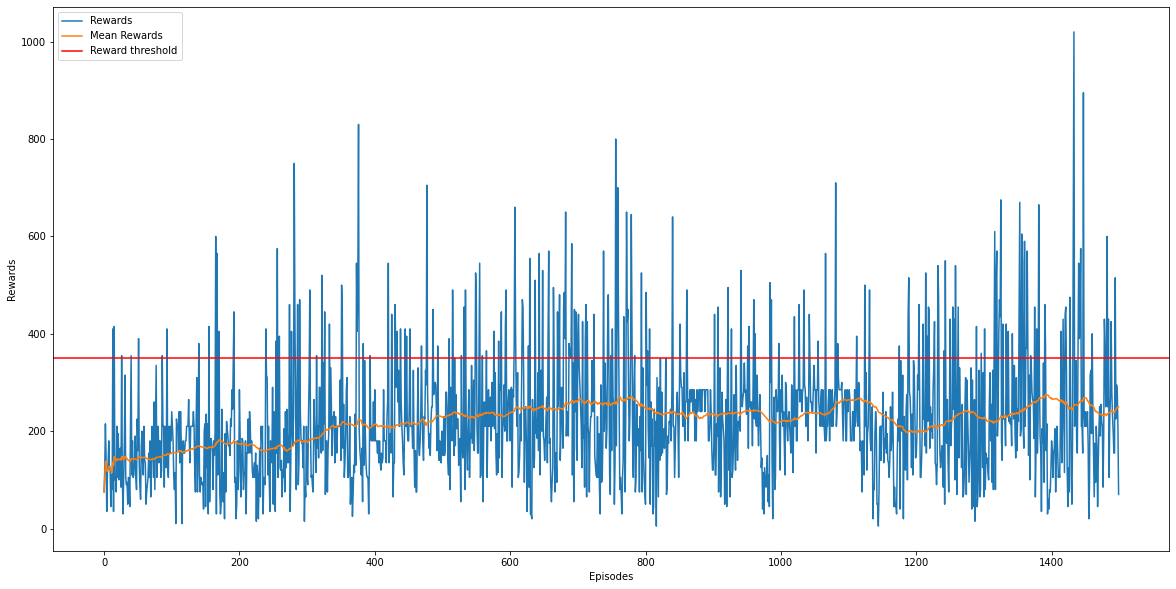

In [32]:
# 1. Recompensas obtenidas a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(ddqn_agent.training_rewards, label='Rewards')
plt.plot(ddqn_agent.mean_training_rewards, label='Mean Rewards')
plt.axhline(ddqn_agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

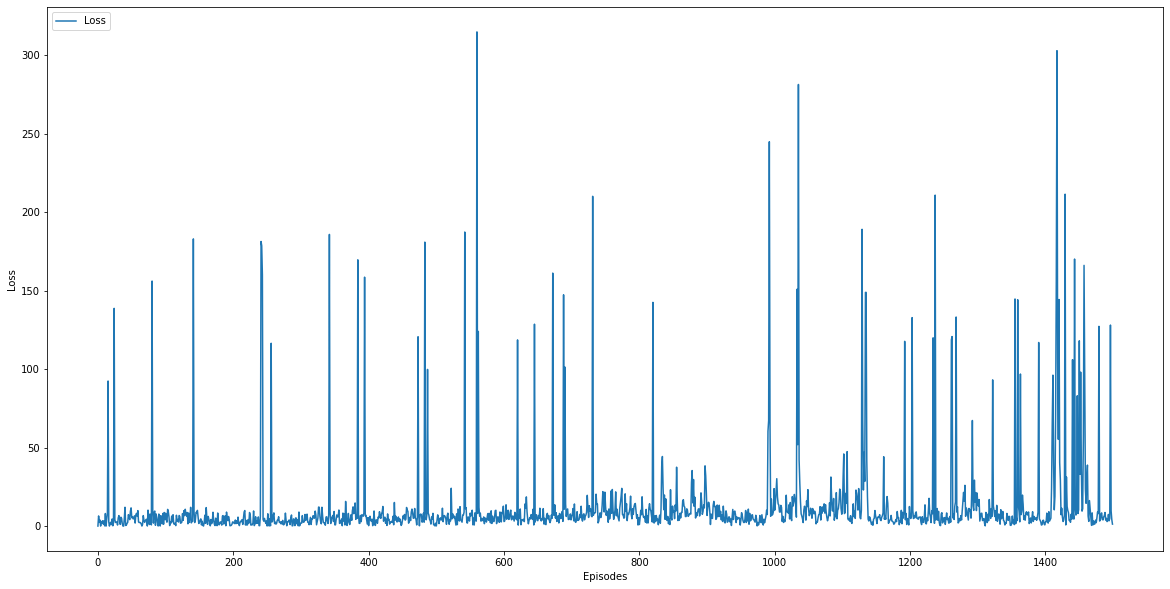

In [33]:
# 2. Evolución de la pérdida a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(ddqn_agent.losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

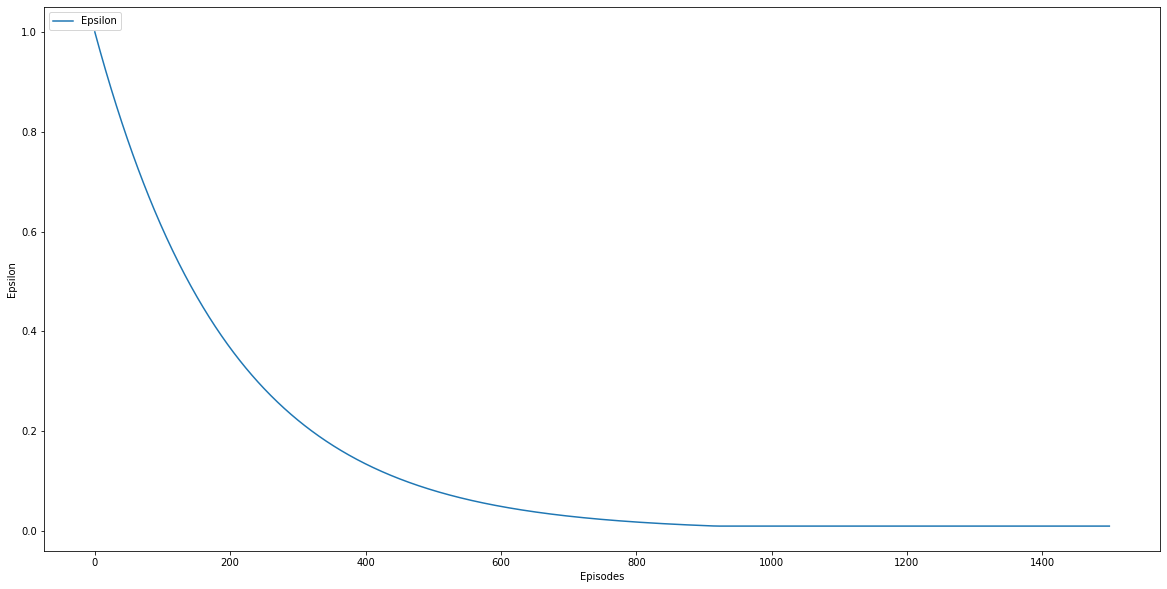

In [34]:
# 3. Evolución de epsilon a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(ddqn_agent.epsilon_history, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.5 (0.1 pto):</strong> Guardar el modelo entrenado en formato ".pth" y comentar los resultados obtenidos.
</div>

In [35]:
torch.save(ddqn_agent.main_network.state_dict(), './models/agentDQN_Trained_Model_dueling_dqn.pth')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.6 (0.1 pto):</strong> Comenta los resultados obtenidos
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>Los resultados son francamente similares al agente anterior, aunque sí es cierto que parece etabilizarse más rápido en el umbral de recompensas entre 180 y 300.
</div>

### 3.4 Test del agente
Finalmente analizamos el comportamiento del agente entrenado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.7 (0.2 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas por cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno.


</div>


In [36]:
# Cargar el modelo de red neuronal
dueling_dqn_test = duelingDQN(env, learning_rate=lr)

# Cargar el agente
agentDuelingDQN = duelingDQNAgent(env, dueling_dqn_test, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

agentDuelingDQN.main_network.load_state_dict(torch.load('./models/agentDQN_Trained_Model_dueling_dqn.pth'))

# Ejecutar los episodios pedidos
episodes = 20
total_rewards = []

for _ in tqdm(range(episodes), ncols=100, desc="Jugando"):
    reward = agent_run(env, agentDuelingDQN)
    total_rewards.append(reward)

Jugando: 100%|██████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.21s/it]


In [37]:
##TODO: Calcular la suma de recompensas
for i, suma in enumerate(total_rewards):
    print(f"Episode {i+1} - {total_rewards[i]}")

Episode 1 - 140.0
Episode 2 - 220.0
Episode 3 - 85.0
Episode 4 - 155.0
Episode 5 - 330.0
Episode 6 - 135.0
Episode 7 - 135.0
Episode 8 - 270.0
Episode 9 - 175.0
Episode 10 - 200.0
Episode 11 - 350.0
Episode 12 - 215.0
Episode 13 - 375.0
Episode 14 - 435.0
Episode 15 - 35.0
Episode 16 - 140.0
Episode 17 - 150.0
Episode 18 - 145.0
Episode 19 - 130.0
Episode 20 - 230.0


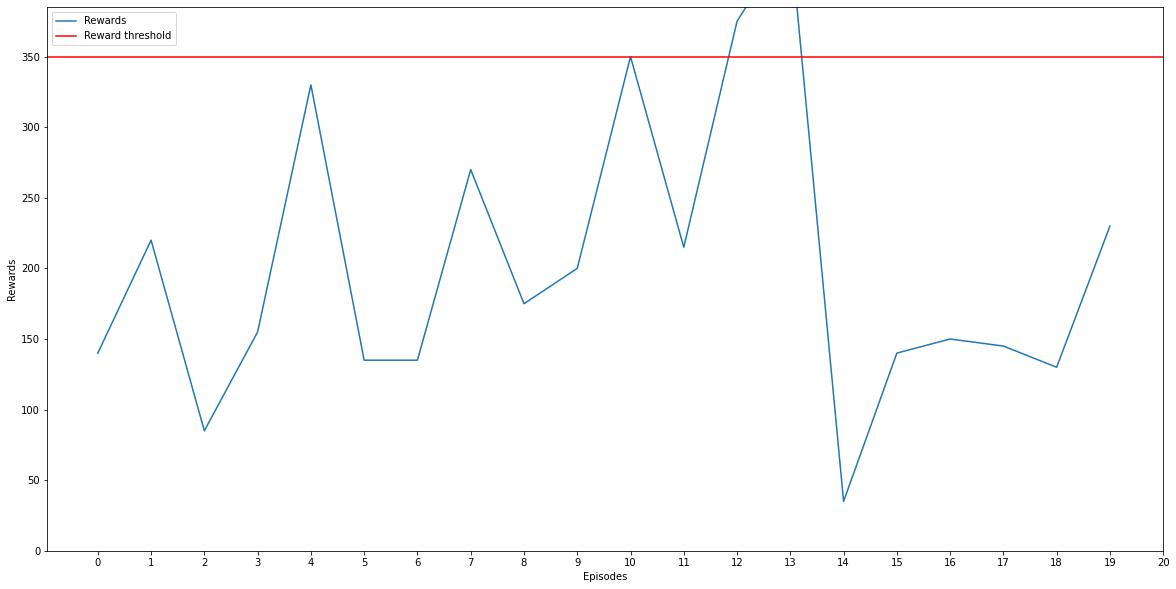

In [38]:
##TODO: realizar las gráficas que se piden
plt.figure(figsize=(20,10))
plt.plot(total_rewards, label='Rewards')
plt.axhline(ddqn_agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.xticks(range(episodes+1))
plt.ylabel('Rewards')
plt.ylim([0,agent.reward_threshold*1.1])
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.8 (0.25 ptos):</strong> Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento y comenta el comportamiento del agente entrenado.
</div>

In [39]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
save_agent_gif(env,agentDuelingDQN , 'space_invader_duelingDQNAgent_comportamiento.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>    
</div>

Este agente, a diferencia del anterior, sí es capaz de disparar y realizar movimientos para esquivar los disparos enemigos. La velocidad con la que ha aprendido este agente es significativamente superior. Se adjunta vídeo del comportamiento de una de las partidas.

![title](videos/space_invader_duelingDQNAgent_comportamiento.gif)

## 4. REINFORCE with baseline (2 ptos)

### 4.1 Definición de la arquitectura  de la red neuronal
Utilizaremos un modelo Secuencial con la siguiente configuración:

<ul>
    <li>Una primera capa del tipo Conv2d con los siguientes parámetros in_channels=(8,64,64), out_channels=32, kernel_size=8, stride=4 con activación ReLU.</li>
    <li>Una segunda capa del tipo Conv2d con los siguientes parámetros in_channels=32, out_channels=64, kernel_size=4, stride=2 con activación ReLU.</li>
    <li>Una tercera capa del tipo Conv2d con los siguientes parámetros in_channels=64, out_channels=64, kernel_size=3, stride=1 con activación ReLU.</li>
</ul>

El resultado de esta primera red lo conectaremos con un modelo complementamente conectado con la siguiente estructura lienal:

* Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, bias=True y  con activación Tanh
* Una última capa completamente conectada. Esta será nuestra capa de salida y, por lo tanto, tendrá tantas neuronas como dimensiones tenga nuestro espacio de acciones (una salida por cada acción posible), bias=True y activación Softmax (dim=-1).

Por último, usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1 (0.5 ptos):</strong> Implementar la clase <code>PGReinforce()</code>. Inicializar las variables necesarias y definir el modelo Secuencial de red neuronal indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [51]:
class PGReinforce(torch.nn.Module):

    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        super(PGReinforce, self).__init__()
         ###################################
        ####TODO: Inicializar variables####
        self.input_shape = [4,84,84]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.device = 'cpu'
        self.learning_rate = learning_rate
        ######

        #######################################
        ##TODO: Construcción de la red neuronal
        self.red_cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        if self.device == 'cuda':
            self.red_cnn.cuda()

        self.fc_layer_inputs = self.feature_size()
        
        self.red_lineal = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, self.n_outputs, bias=True),
            nn.Softmax(dim=-1)
        )

        ### Se ofrece la opción de trabajar con cuda
        if self.device == 'cuda':
            self.red_lineal.cuda()

        #######################################
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #####

    #Obtención de las probabilidades de las posibles acciones
    def get_action_prob(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        return self.red_lineal(cnn_out)

    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)

### 4.2 Definición del agente
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.2 (0.55 pto):</strong> Implementar los siguientes puntos de la clase <code>reinforceAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Calcular el <i>discounted reward</i> usando como línea de base la media estandardizada del retorno
               $$ \frac{x_i - \bar{x}}{\sigma_x}$$</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Implementar la pérdida por actualización</li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [52]:
class reinforceAgent:

    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, dnnetwork, nblock, reward_threshold):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.main_network = dnnetwork
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.initialize()
     #######

    ###############################################################
    #####TODO 2: inicializar variables extra que se necesiten######:
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        
        self.total_reward = 0
        self.step_count = 0
        self.update_loss = []
        self.losses = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.state0 = stack_frame(None, self.env.reset(), True)
    ######

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size

        episode, maximo = 0, 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            incio_juego = self.env.reset()
            state0 = stack_frame(None, incio_juego, True)
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False

            while gamedone == False:
                ##########################################################
                ######TODO 3:  Tomar nueva acción ########################
                action_probs = self.main_network.get_action_prob(state0) #distribución de probabilidad de las acciones dado el estado actual
                action_probs = action_probs.detach().numpy()[0] #se quita la función de optimize, numpy convierte a numpy array, [0] toma únicamente el primer elemento de la matriz
                action = np.random.choice(action_space, p=action_probs) #acción aleatoria de la distribución de probabilidad
                next_state, reward, gamedone, _ = env.step(action)
                #######


                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                next_state = stack_frame(state0, next_state, False)
                state0 = next_state


                if gamedone:
                    episode += 1
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1
                    self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas

                    #####################################################################################
                    ###TODO 5: calcular media de recompensas de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:]) # calculamos la media de recompensa de los últimos X episodios
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = mean_rewards if mean_rewards > maximo else maximo


                    # Actualizamos la red cuando se completa el tamaño del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)

                        ####################################
                        ###TODO : almacenar training_loss###
                        ###########
                        self.losses.append(self.update_loss)

                        self.update_loss = []

                        # Reseteamos las variables del epsiodio
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1


                    print("\rEpisode: {:d} Mean Rewards: {:.2f}\t\tMaximo: {}\t\t".format(
                        episode, mean_rewards, maximo), end="")

                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

    ########################################################
    ###TODO 4: cálculo del retorno menos la línea de base###
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):  #revertimos la dirección del vector para hacer la suma cumulativa
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = np.mean(discount_r) # establecemos la media de la recompensa como línea de base
        return discount_r - baseline     
    ##########


    ## Actualización
    def update(self, batch_s, batch_r, batch_a):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)
        action_t = torch.LongTensor(batch_a)
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.main_network.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

    #################################################
    ###TODO 6: Cálculo de la pérdida#################
    # Recordatorio: cada actualización es proporcional al producto del retorno y el gradiente de la probabilidad
    # de tomar la acción tomada, dividido por la probabilidad de tomar esa acción (logaritmo natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.main_network.get_action_prob(state_t))
        selected_logprobs = reward_t * logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        return loss
     ########

### 4.3 Entrenamiento
A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.005</li>
        <li>Tamaño del batch: 8</li>
        <li>Gamma: 0.99</li>
        <li>Número máximo de episodios: 5000</li>
</ul>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.3 (0.2 ptos):</strong> Definir los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente</div>



In [58]:
lr = 0.005            #Velocidad de aprendizaje
BATCH_SIZE = 8       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
MAX_EPISODES = 1500   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
MIN_EPISODES = 250    #Número mínimo de episodios
MAX_SCORE = 350       #Puntuación establecida para definir la ganancia

# Cargar el modelo de red neuronal
reinforce_dqn = PGReinforce(env, learning_rate=lr)

# Cargar el agente
reinforce_dqn_agent = reinforceAgent(env, reinforce_dqn, 100, MAX_SCORE)

# Entrenar el agente
reinforce_dqn_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE)

Training...
Episode: 1500 Mean Rewards: 270.00		Maximo: 271.6		191919192		
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.4 (0.1 ptos):</strong> Mostrar los siguientes gráficos:
    <ol>
        <li>Recompensas obtenidas a lo largo del entrenamieno y la evolución de las recompensas medias cada 100 episodios, junto con el umbral de recompensa establecido por el entorno</li>
        <li>Pérdida durante el entrenamiento</li>
    </ol>
</div>

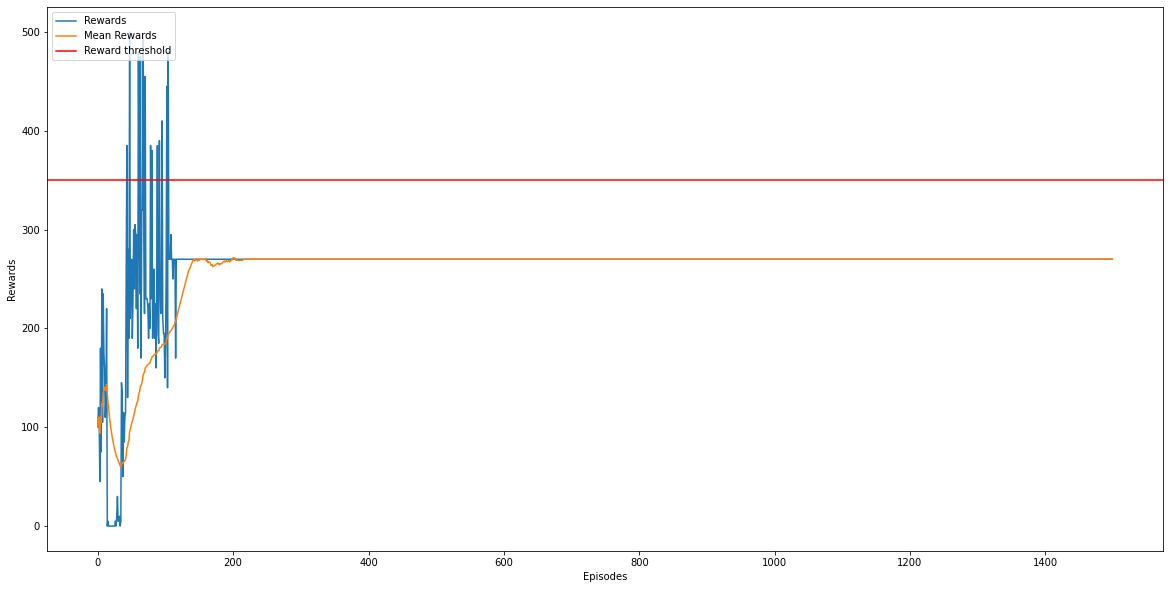

In [59]:
# 1. Recompensas obtenidas a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(reinforce_dqn_agent.training_rewards, label='Rewards')
plt.plot(reinforce_dqn_agent.mean_training_rewards, label='Mean Rewards')
plt.axhline(reinforce_dqn_agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

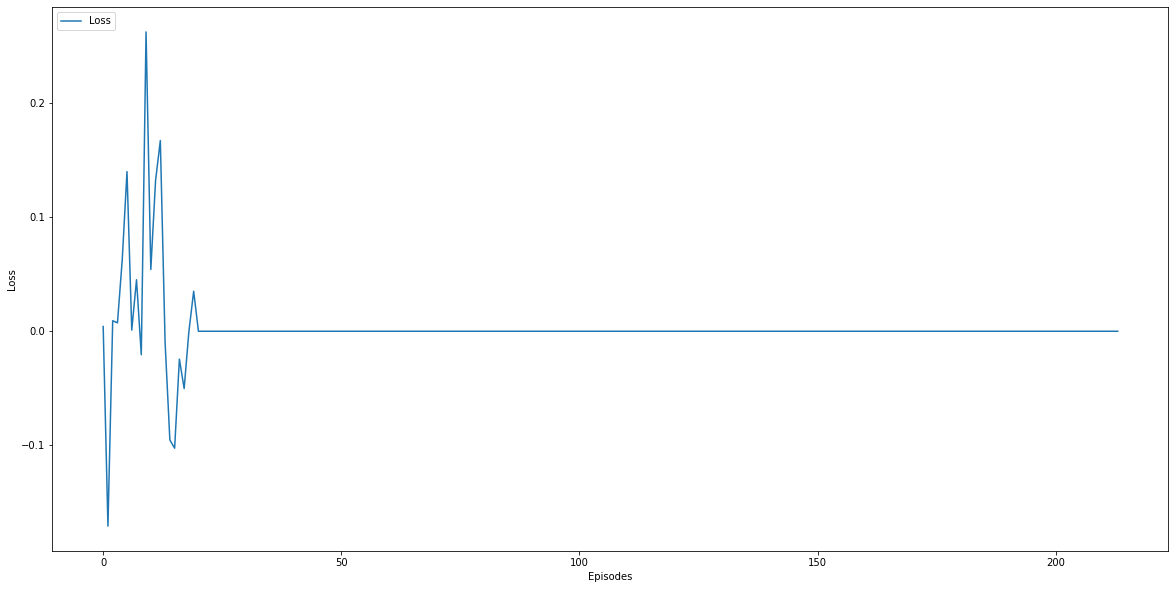

In [60]:
# 2. Evolución de la pérdida a lo largo del entrenamiento

plt.figure(figsize=(20,10))
plt.plot(reinforce_dqn_agent.losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 4.5  (0.2 ptos):</strong> Guardar el modelo entrenado en formato ".pth" y comentar los resultados obtenidos. ¿Qué ha ocurrido con este modelo?
</div>

In [61]:
torch.save(reinforce_dqn_agent.main_network.state_dict(), './models/agentDQN_Trained_Model_reinforce_dqn.pth')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.6 (0.15 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas por cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno. Comentar los resultados.
<p>Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento y coméntalo.</p>
</div>

In [62]:
# Cargar el modelo de red neuronal
reinforce_dqn_test = PGReinforce(env, learning_rate=lr)

# Cargar el agente
agentReinforceDQN = reinforceAgent(env, reinforce_dqn_test, 100, MAX_SCORE)

agentReinforceDQN.main_network.load_state_dict(torch.load('./models/agentDQN_Trained_Model_reinforce_dqn.pth'))


def agent_reinforce_run(env, ag):
    observation = env.reset()
    action_space = np.arange(env.action_space.n)
    state= stack_frame(None, observation, True)
    total_reward = 0
    t=0
    done = False
    while not done:
        state = stack_frame(state, observation, False)
        action_probs = ag.main_network.get_action_prob(state) #distribución de probabilidad de las acciones dado el estado actual
        action_probs = action_probs.detach().numpy()[0] #se quita la función de optimize, numpy convierte a numpy array, [0] toma únicamente el primer elemento de la matriz
        action = np.random.choice(action_space, p=action_probs) #acción aleatoria de la distribución de probabilidad
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1
    env.close()
    return total_reward

# Ejecutar los episodios pedidos
episodes = 20
total_rewards = []

for _ in tqdm(range(episodes), ncols=100, desc="Jugando"):
    reward = agent_reinforce_run(env, agentReinforceDQN)
    total_rewards.append(reward)

Jugando: 100%|██████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.42s/it]


In [63]:
##TODO: Calcular la suma de recompensas
for i, suma in enumerate(total_rewards):
    print(f"Episode {i+1} - {total_rewards[i]}")

Episode 1 - 270.0
Episode 2 - 270.0
Episode 3 - 270.0
Episode 4 - 270.0
Episode 5 - 270.0
Episode 6 - 270.0
Episode 7 - 270.0
Episode 8 - 270.0
Episode 9 - 270.0
Episode 10 - 270.0
Episode 11 - 270.0
Episode 12 - 270.0
Episode 13 - 270.0
Episode 14 - 270.0
Episode 15 - 270.0
Episode 16 - 270.0
Episode 17 - 270.0
Episode 18 - 270.0
Episode 19 - 270.0
Episode 20 - 270.0


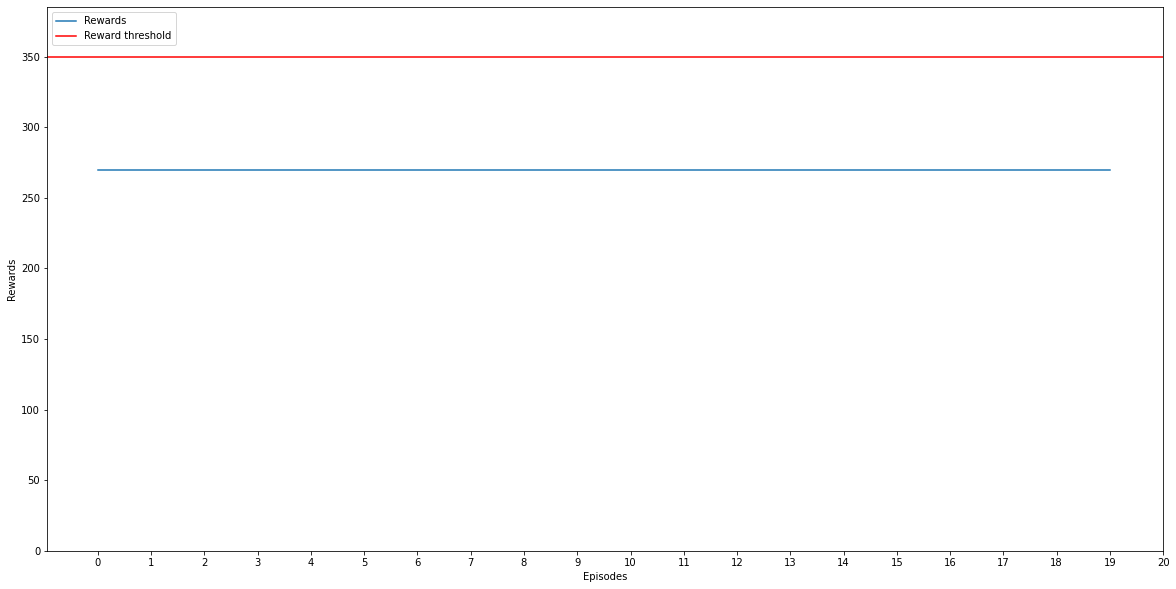

In [64]:
##TODO: realizar las gráficas que se piden
plt.figure(figsize=(20,10))
plt.plot(total_rewards, label='Rewards')
plt.axhline(agentReinforceDQN.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.xticks(range(episodes+1))
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.ylim([0,agent.reward_threshold*1.1])
plt.show()

In [65]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
def save_reinforce_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorno GYM
    :param ag:  agente entrenado
    :param nombre_fichero:  nombre del fichero
    :return:
    '''
    frames = []
    observation = env.reset()
    incio_juego = observation
    action_space = np.arange(env.action_space.n)
    state= stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    done = False
    while not done:
        state = stack_frame(state, observation, False)
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        action_probs = ag.main_network.get_action_prob(state)
        action_probs = action_probs.detach().numpy()[0]
        action = np.random.choice(action_space, p=action_probs)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1

    env.close()
    
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
save_reinforce_agent_gif(env, agentReinforceDQN, 'space_invader_reinforceDQNAgent_comportamiento.gif')

![title](videos/space_invader_reinforceDQNAgent_comportamiento.gif)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
</div>

## 5. Comparación de modelos (1 pto)
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 5.1 (0.5 ptos):</strong> Muestra en un mismo gráfico la evolución de la media de recompensas de los tres modelos, junto con el umbral de recompensa.
</div>

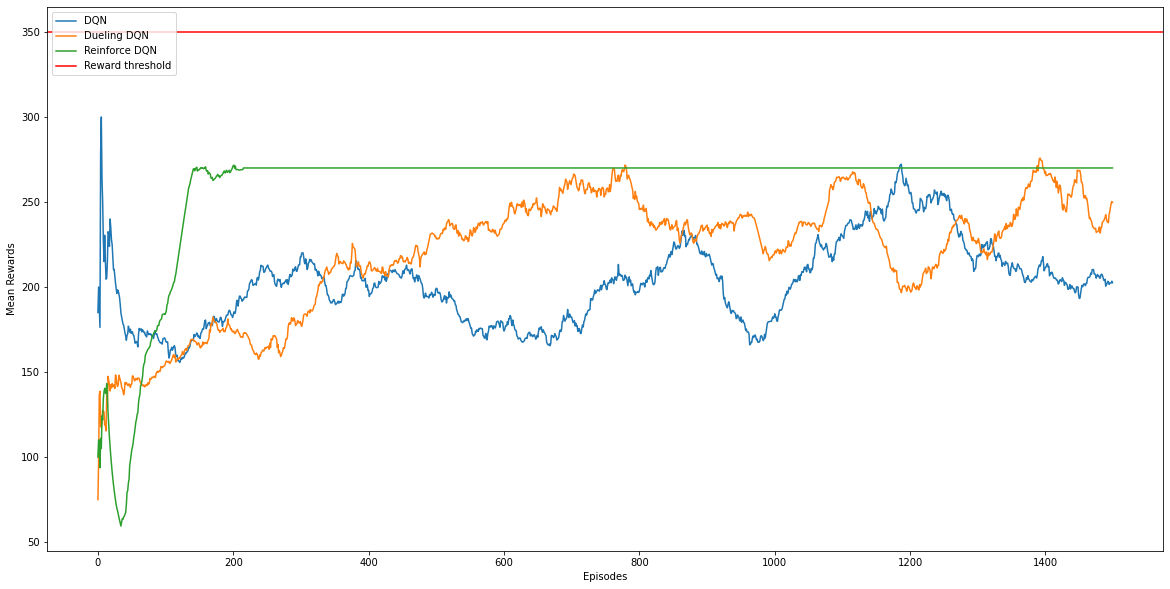

In [66]:
plt.figure(figsize=(20,10))
plt.plot(agent.mean_training_rewards, label='DQN')
plt.plot(ddqn_agent.mean_training_rewards, label='Dueling DQN')
plt.plot(reinforce_dqn_agent.mean_training_rewards, label='Reinforce DQN')
plt.axhline(agentReinforceDQN.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.legend(loc="upper left")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 5.2 (0.5 ptos):</strong> Analizar los resultados obtenidos teniendo en cuenta el número de episodios, el tiempo de entrenamiento y el rendimiento de los tres agentes entrenados observado en apartados anteriores. ¿Qué agente presenta un mejor comportamiento? ¿Por qué?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución (Comentarios):</strong>
<br><br>En función de los datos obtenidos en la gráfica anterios, se puede afirmar que, si bien el agente que alcanza un mayor nivel de recompensa es duelingDQN, sin embargo es mínimamente mayor que al agente Reinforce, que estabiliza en el máximo de recompensas alcanzadas a poco más de los 150 episodios de entrenamiento. El agente del ejercicio 2 DQN, es más lento en su mejora pero aún así está por debajo de los demás.
 
Si por mejor comportamiento se entiende la estabilidad del agente, entonces sin duda el mejor sería Reinforce, puesto que, además de necesitar pocos casos de entrenamiento para alcanzar un nivel de recompensas estable, permite prever las recompensas a futuro con mayor certeza que los demás agentes.
</div>

## 6. Optimización (1 pto)
En este apartado queremos encontrar la mejor arquitectura e hiperparámetros para optimizar la precisión del modelo. Los puntos que queremos tener en cuenta para la búsqueda del mejor modelo son los siguientes:
<ul>
    <li>Número de unidades de las capas</li>
    <li>Learning rate</li>
    <li>Actualización de la red principal</li>
    <li>Sincronización de la red objetivo</li>
    <li>Batch size</li>
    <li>Gamma</li>
    <li>Número de partidas del entrenamiento</li>
<ul>

Podéis modificar o adaptar la configuración cómo consideréis oportuno siempre y cuando justifiquéis el beneficio y el cambio.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 6.1 :</strong> Elegir uno de los dos modelos de DQN implementados (DQN o dueling DQN) y  experimentar con diferentes combinaciones de valores para los parámetros especificados. El objetivo es conseguir un modelo con mejores resultados que el presentado en la PEC. <b>Indicar</b> las pruebas realizadas, pero presentar <b>únicamente</b> la ejecución y resultados de la mejor opción. Justificar los valores elegidos de hiperparámetros para las distintas pruebas realizadas y comentar los resultados de entrenamiento y de rendimiento del agente entrenado.
</div>

El modelo elegido para el entrenamiento y mejora es dueling DQN.

<table>
    <tr>
        <td></td>
        <td>Configuración PEC</td>
        <td>Configuración 1</td>
        <td>Configuración 2</td>
        <td>Configuración 3</td>
    </tr>
    <tr>
        <td>lr</td>
        <td>0.001</td>
        <td>0.1</td>
        <td>0.01</td>
        <td>0.001</td>
    </tr>
    <tr>
        <td>DNN_UPD</td>
        <td>100</td>
        <td>100</td>
        <td>50</td>
        <td>100</td>
    </tr>
    <tr>
        <td>DNN_SYNC</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
    </tr>
    <tr>
        <td>BATCH_SIZE</td>
        <td>32</td>
        <td>32</td>
        <td>64</td>
        <td>64</td>
    </tr>
    <tr>
        <td>GAMMA</td>
        <td>0.99</td>
        <td>0.01</td>
        <td>0.001</td>
        <td>0.001</td>
    </tr>
    <tr>
        <td>MAX_EPISODES</td>
        <td>1500</td>
        <td>1500</td>
        <td>1500</td>
        <td>1500</td>
    </tr>
    <tr>
        <td><strong>MEAN TRAINING REWARD</strong></td>
        <td><strong>113.70</strong></td>
        <td><strong>155.77</strong></td>
        <td><strong>190.52</strong></td>
        <td><strong>262.90</strong></td>
    </tr>
    <tr>
        <td><strong>MAX REWARD</strong></td>
        <td><strong>273.25</strong></td>
        <td><strong>225.00</strong></td>
        <td><strong>226.43</strong></td>
        <td><strong>272.10</strong></td>
    </tr>
</table>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>
</div>

<strong>Configuración 1</strong>. Se buscó optimizar el modelo modificando el learning rate, de cara a acelerar el avance hacia el mínimo en cada paso, así como también el gamma, para darle menos importancia a los movimientos futuros, permitiendo al agente prestar más importancia a la inmediatez. El resto de los parámetros se mantuvieron como en la PEC. Si bien el modelo es un poco "más bruto", el _mean reward_ mejora su valor aunque muy poco con respecto a los demás que vienen a continuación.

<strong>Configuración 2</strong>. En esta configuración, refinamos un poco nuevamente el learning rate para mejorar el nivel de aproximación del agente, así como la cantidad de iteraciones del actualización de la red principal. El gamma es incluso más pequeño para priorizar la inmediatez de las recompensas. El modelo mejora significativamente puesto que el _mean reward_ mejora en un 70% con respecto al modelo inicial.

<strong>Configuración 3</strong>. Para esta última prueba, se dejó el learning rate a 0.001 como en la PEC, permitiendo una granuliaridad más fina a la hora de optimizar, pero se aumentó el batch size al doble, por lo que ahora la red procesaría más casos de manera más rápida. El gamma se mantiene en el 0.001 para priorizar las recompensas inmediatas frente a las futuras. Esta configuración presente aun modelo significativamente mejorado, donde el _mean reward_ alcanza los 262.90, un 132% mejor rendimiento que en el caso inicial.